In [1]:
from tensorboard.backend.event_processing import event_accumulator      
import numpy as np
import pandas as pd
from glob import glob
import sys
import tensorboard.plugins.hparams as hparams
from tensorboard.plugins.hparams import plugin_data_pb2
import tqdm
import re
import os.path
import os

interesting_keys = ['episode_reward_mean', "episode_len_mean", 'episodes_total', 'custom_metrics/inv', "time_this_iter_s", 'custom_metrics/accept']
hist_keys = ["inv", "accept"]


def create_df(inpath):
    sg = {event_accumulator.COMPRESSED_HISTOGRAMS: 1,
          event_accumulator.IMAGES: 1,
          event_accumulator.AUDIO: 1,
          event_accumulator.SCALARS: 0,
          event_accumulator.HISTOGRAMS: 0}
    ea = event_accumulator.EventAccumulator(inpath, size_guidance=sg)
    ea.Reload()
    scalar_tags = ea.Tags()['scalars']
    df = pd.DataFrame()
    events = ea.Scalars("ray/tune/episode_reward_mean")
    ids = [x.step for x in events]
    ids_s = set(x.step for x in events)
    df['step'] = ids
    walltimes = [x.wall_time for x in events]
    df['walltime'] = walltimes
    df['totalwalltime'] = walltimes[-1] - walltimes[0]
    df.set_index('step', inplace=True)
    for tag in hist_keys:
        fulltag = 'ray/tune/hist_stats/' + tag
        events = ea.Histograms(fulltag)
        indexes = [x.step for x in events if x.step in ids_s]
        mins = [x.histogram_value.min
                for x in events if x.step in ids_s]
        maxs = [x.histogram_value.max 
                for x in events if x.step in ids_s]
        means = [x.histogram_value.sum / x.histogram_value.num 
                 for x in events if x.step in ids_s]
        variances = [np.max((0, x.histogram_value.sum_squares / x.histogram_value.num - (x.histogram_value.sum / x.histogram_value.num)**2))
                     for x, mean in zip(events, means) if x.step in ids_s]
        stds = np.sqrt(variances)
        #print(events[-1].histogram_value)
        df.loc[indexes, tag+"_max"] = maxs
        df.loc[indexes, tag+"_min"] = mins
        df.loc[indexes, tag+"_mean"] = means
        df.loc[indexes, tag+"_std"] = stds
    for tag in interesting_keys:
        fultag = 'ray/tune/' + tag
        success = False
        for i in range(3):
            try:
                events = ea.Scalars(fultag)
            except KeyError:
                fultag+= "_mean"
            else:
                success = True
                break
        if not success:
            raise KeyError(fultag)

        scalars = np.array([x.value for x in events if x.step in ids_s])
        indexes = np.array([x.step for x in events if x.step in ids_s])
        df.loc[indexes, tag] = scalars

    df.reset_index(inplace=True)
    return df


def removeprefix(self: str, prefix: str, /) -> str:
    if self.startswith(prefix):
        return self[len(prefix):]
    else:
        return self[:]

In [2]:
nepisodes=200000
mainpath = f'logs/paperrun2/e{nepisodes}/ppobiglr/**/*tfevents*'
first, _ = mainpath.split("**")

shortname = ''.join(removeprefix(first, 'logs/').split('/'))
print(shortname)

figdir = "figures/" + shortname + "/"
os.makedirs(figdir, exist_ok=True)

paperrun2e200000ppobiglr


In [3]:
fuldfs = []
runid = 0
forcereload = False

if not forcereload and os.path.exists(first + "/sumup.df.pkl"):
    alldf = pd.read_pickle(first + "/sumup.df.pkl")
else:
    for path in tqdm.tqdm(glob(mainpath, recursive=True)):
        try:
            curdf = create_df(path)
        except Exception as e:
            print(path)
            print(type(e), e)
        else:
            curdf['run'] = runid
            curdf['badsiteprob'] = float(re.search("good_site_prob=(.+?),", path).group(1))
            curdf['trial_id'] = re.search(r"partner_choice_(.+)_(?:\d+)_good", path).group(1)
            fuldfs.append(curdf)
            runid += 1
    alldf = pd.concat(fuldfs)
    first, _ = mainpath.split("**")
    binsize = 1000
    mode = "ppo"
    if "cma" in mainpath: 
        mode = "cma"
    else:
        mode = "ppo"
    ps = [1, 0.5, 0.2, 0.1]
    if "true_episode_reward_mean" not in alldf.columns:
        alldf["true_episode_reward_mean"] = alldf["episode_reward_mean"]
    if mode == "ppo": 
        alldf["episode_reward_mean"] = alldf["true_episode_reward_mean"] / 2
    if "p" not in alldf.columns:
        alldf["p"] = alldf["badsiteprob"]

    alldf["episode_bin_right"] = alldf["episodes_total"].apply(lambda x: (x // binsize + 1) * binsize )
    alldf["step_bin_right"] = alldf["step"].apply(lambda x: (x // binsize + 1) * binsize )
    alldfful = alldf
    alldf = alldf.query("p in @ps").copy()
    alldf.to_pickle(first + "/sumup.df.pkl")


In [4]:
figwidth = 3.3

In [5]:
binsize = nepisodes//200
stepbin = alldf["step"].max() // 300
print(binsize)
print(stepbin)

if "cma" in mainpath: 
    mode = "cma"
else:
    mode = "ppo"
ps = [1, 0.5, 0.2, 0.1]
alldf = alldf.query("p in @ps").copy()

if "true_episode_reward_mean" not in alldf.columns:
    alldf["true_episode_reward_mean"] = alldf["episode_reward_mean"]
if mode == "ppo": 
    alldf["episode_reward_mean"] = alldf["true_episode_reward_mean"] / 2
if "p" not in alldf.columns:
    alldf["p"] = alldf["badsiteprob"]


alldf["episode_bin_right"] = alldf["episodes_total"].apply(lambda x: (x // binsize + 1) * binsize )
alldf = alldf.query("episode_bin_right <= (@nepisodes + @binsize)")
alldf["episode_bin_right"].where(alldf["episode_bin_right"] <= nepisodes, nepisodes, inplace=True)
alldf["step_bin_right"] = alldf["step"].apply(lambda x: (x // binsize + 1) * binsize )
alldf = alldf.query("p in @ps").copy()
alldf.to_pickle(first + "/sumup.df.pkl")

1000
80917


In [6]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set()
sns.set_palette('colorblind')
sns.set_context('paper', font_scale=0.75)
sns.set_style("whitegrid")
figsize=(figwidth, figwidth/1.5)

In [7]:
alldf.query("p == 1").groupby("run").max()

,step,walltime,totalwalltime,inv_max,inv_min,inv_mean,inv_std,accept_max,accept_min,accept_mean,...,episodes_total,custom_metrics/inv,time_this_iter_s,custom_metrics/accept,badsiteprob,trial_id,true_episode_reward_mean,p,episode_bin_right,step_bin_right
run,,,,,,,,,,,,,,,,,,,,,
25,3872000,1.606409e+09,3103.734086,12.313759,9.581698,9.673524,1.425829,10.5,9.5,9.500000,...,200365.0,9.676275,7.047950,9.500000,1.0,b60b6_00002,98.660538,1.0,200000.0,3873000
26,3795200,1.606461e+09,45131.825865,10.911381,8.698144,8.842240,1.229536,10.0,8.0,8.281250,...,200141.0,8.847029,6.684581,8.281250,1.0,b60b6_00022,94.390472,1.0,200000.0,3796000
27,3667200,1.606409e+09,2902.802981,12.029014,9.569939,9.622183,1.502908,11.0,8.5,9.095652,...,200264.0,9.627609,6.689610,9.095653,1.0,b60b6_00007,95.013306,1.0,200000.0,3668000
28,3475200,1.606414e+09,5381.817462,10.589926,8.697174,8.840445,1.243398,10.0,8.0,8.465753,...,200105.0,8.840518,7.485802,8.465754,1.0,b60b6_00011,94.981544,1.0,200000.0,3476000
31,3795200,1.606409e+09,3037.169231,10.139138,8.200131,8.220261,1.178658,10.0,7.5,7.772093,...,200038.0,8.220352,6.856089,7.772093,1.0,b60b6_00003,92.992401,1.0,200000.0,3796000
32,3641600,1.606460e+09,44826.728249,15.000000,9.718592,9.740658,1.878256,13.5,9.0,9.260526,...,200207.0,9.740884,5.569133,9.260527,1.0,b60b6_00021,96.147301,1.0,200000.0,3642000
37,3769600,1.606460e+09,45634.094663,11.789770,9.122020,9.158581,1.161338,11.0,8.5,8.979839,...,200146.0,9.178609,6.767929,8.979838,1.0,b60b6_00020,96.813484,1.0,200000.0,3770000
39,4012800,1.606452e+09,39035.674453,9.811823,7.580003,7.642696,1.022863,9.5,7.0,7.495495,...,200286.0,7.642962,5.724575,7.495495,1.0,b60b6_00017,91.982269,1.0,200000.0,4013000
42,3731200,1.606461e+09,44099.764478,10.955429,9.534378,9.602401,1.328773,10.5,9.0,9.269231,...,200115.0,9.603431,6.284029,9.269231,1.0,b60b6_00023,96.904877,1.0,200000.0,3732000


In [8]:
from pandas.api.types import CategoricalDtype
ps = [1, 0.5, 0.2, 0.1]
step = False
epcollapsed = alldf.groupby(["p", "run", "episode_bin_right"], as_index=False).mean()
print("ep done")
if step:
    stepcollapsed = alldf[["p", "run", "step_bin_right", "inv_mean", "inv_std", "accept_mean"]].groupby(["p", "run", "step_bin_right"], as_index=False).mean()
    stepcollapsed["p"] = stepcollapsed["p"].astype(pcat)

print("step done")
pcat = CategoricalDtype(ps, ordered=True)
epcollapsed["p"] = epcollapsed["p"].astype(pcat)
print("p as cat done")
alldf["p"] = alldf["p"].astype(pcat)

ep done
step done
p as cat done


In [9]:
print("ok")
print(epcollapsed.query("episode_bin_right >= @nepisodes").groupby("p").nunique())

ok
     run  episode_bin_right  step  walltime  totalwalltime  inv_max  inv_min  \
p                                                                              
1.0   24                  1    23        24             24       24       24   
0.5   24                  1    24        24             24       24       24   
0.2   24                  1    24        24             24       24       24   
0.1   24                  1    24        24             24       24       24   

     inv_mean  inv_std  accept_max  ...  accept_std  episode_reward_mean  \
p                                   ...                                    
1.0        24       24           5  ...          24                   24   
0.5        24       24           6  ...          24                   24   
0.2        24       24           8  ...          24                   24   
0.1        24       24          10  ...          24                   24   

     episode_len_mean  episodes_total  custom_metrics/inv  

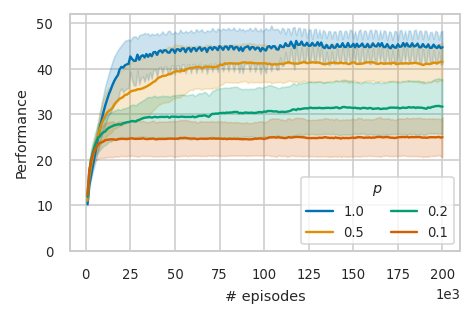

In [17]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
#sns.lineplot(
#    data=epcollapsed, x="episode_bin_right", y='episode_reward_mean', hue="p",
#    estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
#)

sns.lineplot(data=epcollapsed, x="episode_bin_right", y='episode_reward_mean', hue="p", ax=ax, ci="sd")

ax.ticklabel_format(axis="x", scilimits=(3, 3))
plt.ylim(0, 52)
plt.ylabel('Performance')
plt.xlabel('# episodes')
plt.legend(ncol=2, title="$p$")
plt.tight_layout()
plt.savefig(figdir + "reward_mean_synth.pdf")

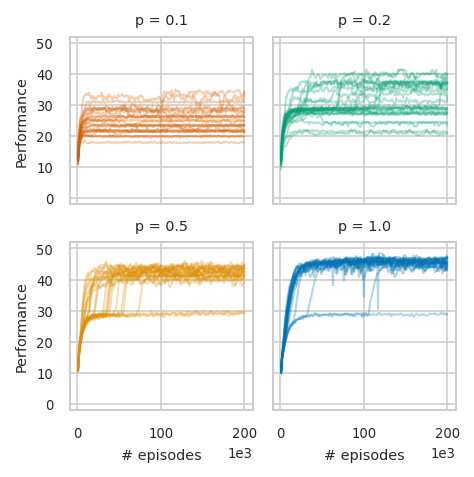

In [11]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=(figwidth/2), aspect=1, hue="p", despine=False, col_order=[0.1, 0.2, 0.5, 1.0])
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_reward_mean',
        estimator=None, alpha=0.3, linewidth=1, units="run")
#g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_reward_mean')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
    ax.set_yticks([i for i in range(0, 51, 10)])
    ax.set_ylim(-2, 52)
g.set_axis_labels("# episodes", "Performance")
g.tight_layout()
g.savefig(figdir + "reward_mean_detail.pdf")

In [12]:
epcollapsed.query("episode_bin_right == @nepisodes and episode_reward_mean <= 40").groupby("p").nunique()

,run,episode_bin_right,step,walltime,totalwalltime,inv_max,inv_min,inv_mean,inv_std,accept_max,...,accept_std,episode_reward_mean,episode_len_mean,episodes_total,custom_metrics/inv,time_this_iter_s,custom_metrics/accept,badsiteprob,true_episode_reward_mean,step_bin_right
p,,,,,,,,,,,,,,,,,,,,,
1.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0.5,3,1,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,1,3,3
0.2,23,1,23,23,23,23,23,23,23,8,...,23,23,23,23,23,23,23,2,23,23
0.1,24,1,24,24,24,24,24,24,24,10,...,24,24,24,24,24,24,24,3,24,24


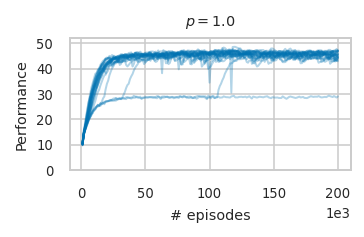

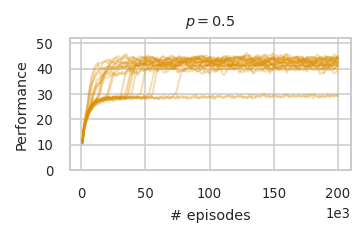

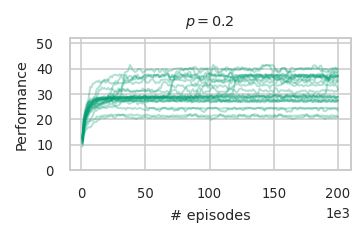

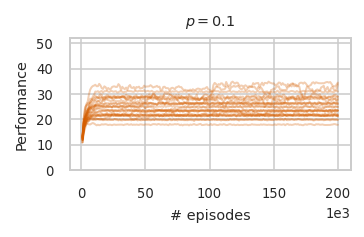

In [13]:
for i, (name, group) in enumerate(epcollapsed.groupby("p")):
    fig = plt.figure(figsize=(figwidth/1.3, figwidth/2))
    ax = fig.gca()
    sns.lineplot(data=group, x="episode_bin_right", y="episode_reward_mean", estimator=None, units="run", alpha=0.3, linewidth=1, color=sns.color_palette()[i])
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
    ax.set_ylabel("Performance")
    ax.set_xlabel("# episodes")
    ax.set_title(f"$p = {name}$")
    ax.set_ylim(0, 52)
    ax.set_yticks([i for i in range(0, 51, 10)])
    fig.tight_layout()
    fig.savefig(figdir + f"reward_mean_detail_p{name}.pdf")
    plt.show(fig)

In [14]:
if step:
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    sns.lineplot(
            data=stepcollapsed, x="step_bin_right", y='episode_reward_mean', hue="p",
            estimator=None, linewidth=1, ax=ax, units="run"
        )
    ax.ticklabel_format(axis="x", scilimits=(6, 6))

    plt.ylim(0, 50)
    plt.ylabel('Performance')
    plt.xlabel('# step')
    plt.legend(ncol=2, title="$p$")
    plt.tight_layout()
    plt.savefig(figdir + "reward_mean_synth_step.pdf")

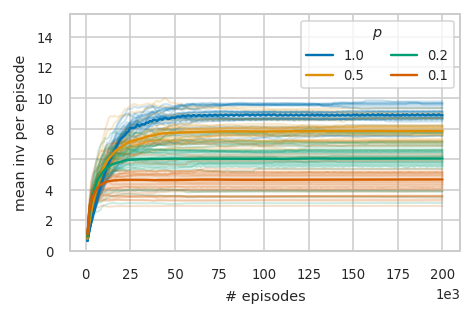

In [15]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
sns.lineplot(
        data=epcollapsed, x="episode_bin_right", y='custom_metrics/inv', hue="p",
        estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
    )

sns.lineplot(data=epcollapsed, x="episode_bin_right", y='custom_metrics/inv', hue="p", ax=ax)

plt.ylim(0, 15.5)
plt.ylabel('mean inv per episode')
plt.xlabel('# episodes')
plt.legend(ncol=2, title="$p$")
ax.ticklabel_format(axis="x", scilimits=(3, 3))
plt.tight_layout()
plt.savefig(figdir + "inv_mean_synth.pdf")

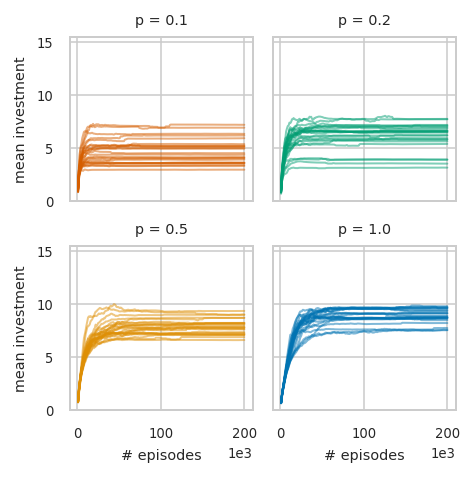

In [16]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/2, aspect=1, sharex=True, hue="p", despine=False, col_order=[0.1, 0.2, 0.5, 1.0])
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='custom_metrics/inv',
        estimator=None, alpha=0.5, linewidth=1, units="run")
#g.map_dataframe(sns.lineplot, x="episode_bin_right", y='custom_metrics/inv')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
    ax.set_ylim(0, 15.5)
g.set_axis_labels("# episodes", "mean investment")
g.tight_layout()
g.savefig(figdir + "inv_mean_details.pdf")

In [17]:
if step:
    plt.figure(figsize=figsize)

    sns.lineplot(data=alldf, x="step", y='custom_metrics/inv', hue="badsiteprob", units="run", estimator=None)
    plt.ylim(0, 15)
    plt.ylabel('mean inv per episode')
    plt.xlabel('# steps')
    plt.legend(title="$p$")
    plt.tight_layout()
    plt.savefig(figdir + "inv_mean_synth_step.pdf")

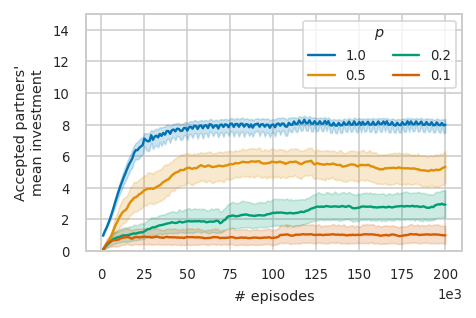

In [18]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
#sns.lineplot(
#        data=epcollapsed, x="episode_bin_right", y='custom_metrics/accept', hue="p",
#        estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
#    )

sns.lineplot(data=epcollapsed, x="episode_bin_right", y='custom_metrics/accept', hue="p", ax=ax)


plt.ylim(0, 15)
plt.ylabel('Accepted partners\'\nmean investment')
plt.xlabel('# episodes')
plt.legend(title="$p$", ncol=2)
ax.ticklabel_format(axis="x", scilimits=(3, 3))
plt.tight_layout()
plt.savefig(figdir + "accept_mean_synth.pdf")

In [19]:
if step:
    plt.figure(figsize=figsize)

    sns.lineplot(data=alldf, x="step", y='custom_metrics/accept', hue="p", units="run", estimator=None)
    plt.ylim(0, 15)
    plt.ylabel('mean accept per episode')
    plt.xlabel('# steps')
    plt.legend(title="$p$")
    plt.tight_layout()
    plt.savefig(figdir + "accept_mean_step.pdf")

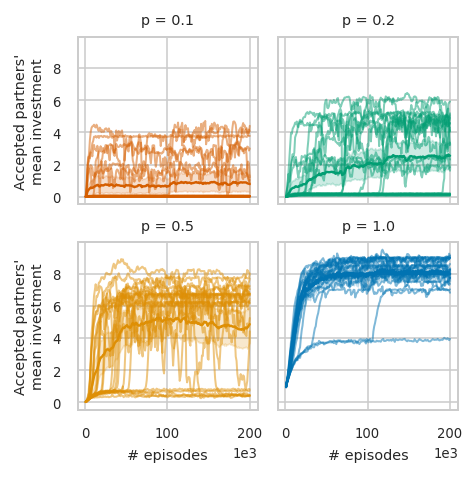

In [20]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1, hue="p", despine=False, col_order=[0.1, 0.2, 0.5, 1.0])
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_mean',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_mean')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.set_axis_labels("# episodes", "Accepted partners'\nmean investment")
g.tight_layout()

plt.savefig(figdir + "accept_mean_detail.pdf")

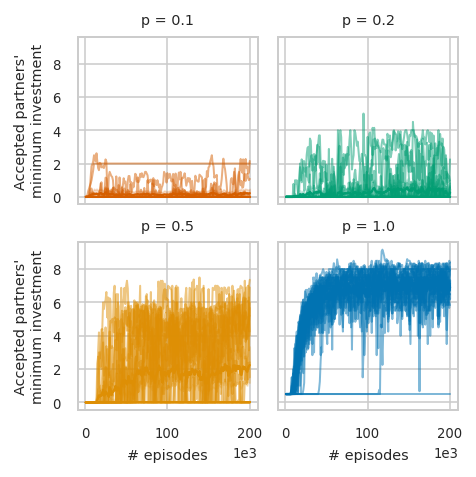

In [21]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1, hue="p", despine=False, col_order=[0.1, 0.2, 0.5, 1.0])
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_min',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_min')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.set_axis_labels("# episodes", "Accepted partners'\nminimum investment")

g.tight_layout()
plt.savefig(figdir + "accept_min_detail.pdf")

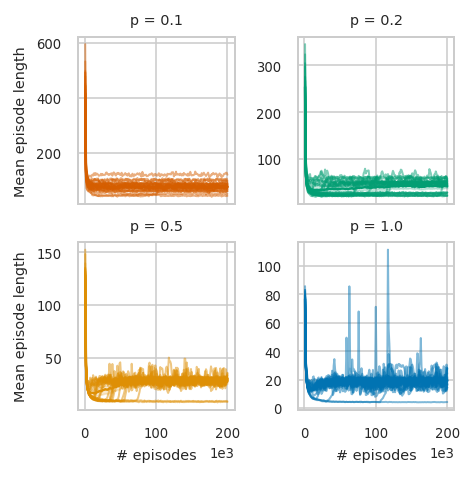

In [22]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=(figwidth/(1*2)), aspect=1, sharey=False, hue="p",
                  despine=False, col_order=[0.1, 0.2, 0.5, 1.0])
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_len_mean',
        estimator=None, alpha=0.5, linewidth=1, units="run", )
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_len_mean')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.set_axis_labels("# episodes", "Mean episode length")
g.tight_layout()

plt.savefig(figdir + "episode_mean_detail.pdf")

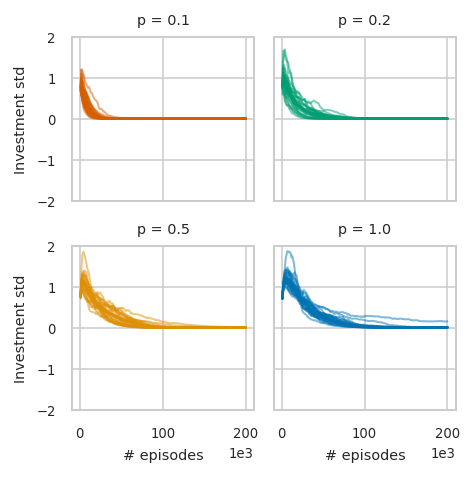

In [23]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1, hue="p", despine=False,
                 col_order=[0.1, 0.2, 0.5, 1.0])
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='inv_std',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='inv_std')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.set(ylim=(-2, 2))
g.set_axis_labels("# episodes", "Investment std")
g.tight_layout()

plt.savefig(figdir + "inv_std_detail.pdf")

In [24]:
outalldf = pd.read_pickle("logs/exectime/e200000/ppobiglr/sumup.df.pkl")
out = outalldf.groupby(["p", "run"], as_index=False).apply(lambda x: x[x.step == x.step.max()])
outalldf = pd.read_pickle("logs/paperrun2/e200000/cmafixed/sumup.df.pkl")
outcma = outalldf.groupby(["p", "run"], as_index=False).apply(lambda x: x[x.step == x.step.max()])

In [25]:
out["timeperit"] = out["totalwalltime"] / out["step"] * 1000
outcma["timeperit"] = outcma["totalwalltime"] / outcma["step"] * 1000

In [26]:
out[["p", "run", "step", "totalwalltime", "timeperit"]]

,,p,run,step,totalwalltime,timeperit
0,2974,0.1,48,11900000,574576.485581,48.283738
1,3113,0.1,49,12456000,575462.643821,46.199634
2,3126,0.1,50,12508000,575172.991090,45.984409
3,3165,0.1,51,12664000,575469.803388,45.441393
4,3112,0.1,52,12452000,574356.593693,46.125650
...,...,...,...,...,...,...
91,947,1.0,34,3792000,173344.155316,45.713121
92,929,1.0,37,3720000,165623.576173,44.522467
93,962,1.0,40,3852000,171133.616492,44.427211
94,948,1.0,41,3796000,164848.717638,43.426954


In [27]:
outcma[["p", "run", "step", "totalwalltime", "timeperit"]]

,,p,run,step,totalwalltime,timeperit
0,1998,0.1,0,124528086,151785.163402,1.218883
1,1998,0.1,1,126413164,154737.131274,1.224059
2,1998,0.1,2,148246910,170382.527705,1.149316
3,1998,0.1,3,137812720,163437.483320,1.185939
4,1998,0.1,4,135175572,160620.262085,1.188234
...,...,...,...,...,...,...
91,1998,1.0,67,1035224,2167.217888,2.093477
92,1998,1.0,68,12786344,15904.359900,1.243855
93,1998,1.0,69,13068022,16327.609320,1.249432
94,1998,1.0,70,12975658,16316.919803,1.257502


In [28]:
outcma["Algorithm"] = "CMA-ES"

out["Algorithm"] = "PPO"

outcomb = pd.concat((outcma, out))

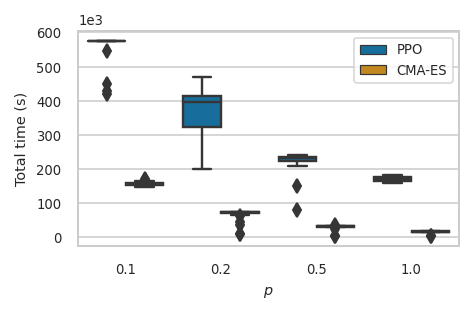

In [29]:
plt.figure(figsize=figsize)
sns.boxplot(data=outcomb, x="p", hue="Algorithm", y="totalwalltime", hue_order=["PPO", "CMA-ES"], dodge=True)
plt.ylabel("Total time (s)")
plt.xlabel("$p$")
plt.ticklabel_format(axis="y", scilimits=(3, 3))
plt.legend()
plt.tight_layout()
plt.savefig("figures/paperrun2e200000/total_time.pdf")

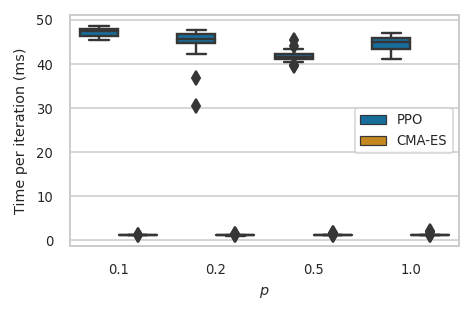

In [30]:
plt.figure(figsize=figsize)
sns.boxplot(data=outcomb, x="p", hue="Algorithm", y="timeperit", hue_order=["PPO", "CMA-ES"], dodge = True)
plt.ylabel("Time per iteration (ms)")
plt.xlabel("$p$")
plt.legend()
plt.tight_layout()
plt.savefig("figures/paperrun2e200000/time_per_it.pdf")

In [31]:
outcomb["totalwalltimehour"] = outcomb["totalwalltime"] / (60*60)


In [32]:
outcomb.groupby(["p", "Algorithm"])[["totalwalltimehour", "timeperit"]].agg(["mean", "std"]).style.format(
    {("totalwalltimehour", "mean"): "{:2.2f}",
     ("totalwalltimehour", "std"): "{:2.2f}",
    ("timeperit", "mean"): "{:2.2f}",
    ("timeperit", "std"): "{:2.2f}",})

In [33]:
pd.options.display.float_format = '{:,.2f}'.format
print(outcomb.groupby(["p", "Algorithm"])[["totalwalltimehour", "timeperit"]].agg(["mean", "std"]).to_latex())

\begin{tabular}{llrrrr}
\toprule
     &     & \multicolumn{2}{l}{totalwalltimehour} & \multicolumn{2}{l}{timeperit} \\
     &     &              mean &   std &      mean &  std \\
p & Algorithm &                   &       &           &      \\
\midrule
0.10 & CMA-ES &             43.31 &  1.46 &      1.21 & 0.02 \\
     & PPO &            154.53 & 13.44 &     47.14 & 0.99 \\
0.20 & CMA-ES &             17.68 &  5.40 &      1.17 & 0.07 \\
     & PPO &            102.69 & 18.35 &     44.71 & 3.77 \\
0.50 & CMA-ES &              7.95 &  2.18 &      1.26 & 0.14 \\
     & PPO &             61.01 &  9.82 &     41.80 & 1.31 \\
1.00 & CMA-ES &              4.10 &  1.07 &      1.32 & 0.23 \\
     & PPO &             47.11 &  1.87 &     44.54 & 1.75 \\
\bottomrule
\end{tabular}



In [34]:
outalldf = pd.read_pickle("logs/paperrun2/e200000/ppobiglr/sumup.df.pkl")
out = outalldf.groupby(["p", "run"], as_index=False).apply(lambda x: x[x.step == x.step.max()])
outalldf = pd.read_pickle("logs/paperrun2/e200000/cmafixed/sumup.df.pkl")
outcma = outalldf.groupby(["p", "run"], as_index=False).apply(lambda x: x[x.step == x.step.max()])
outcma["Algorithm"] = "CMA-ES"

out["Algorithm"] = "PPO"
out["timeperit"] = out["totalwalltime"] / out["step"] * 1000
outcma["timeperit"] = outcma["totalwalltime"] / outcma["step"] * 1000
outcomb = pd.concat((outcma, out))
outcomb["totalwalltimehour"] = outcomb["totalwalltime"] / (60*60)


In [35]:
outcomb.groupby(["p", "Algorithm"])[["totalwalltimehour", "timeperit"]].agg(["mean", "std"]).style.format(
    {("totalwalltimehour", "mean"): "{:2.2f}",
     ("totalwalltimehour", "std"): "{:2.2f}",
    ("timeperit", "mean"): "{:2.2f}",
    ("timeperit", "std"): "{:2.2f}",})